In [2]:
from test_hmmbatchcd import *

# 3 Tests

Hamming Distance =  0.499


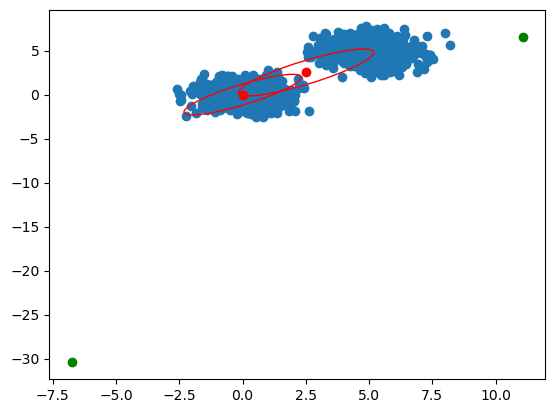

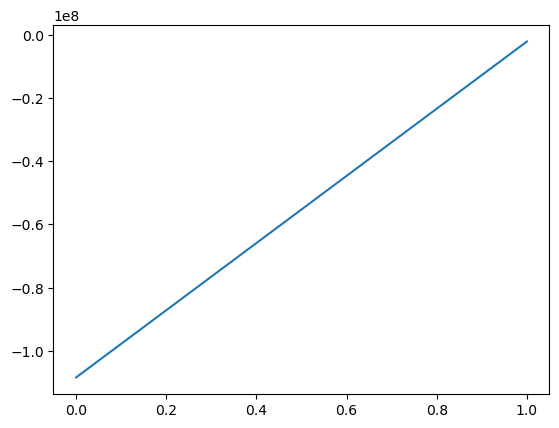

Hamming Distance =  0.499


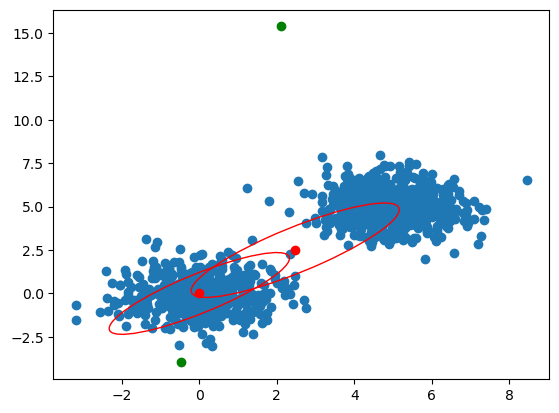

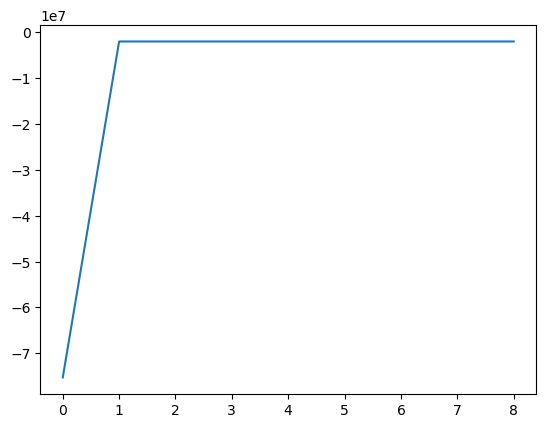

Hamming Distance =  0.499


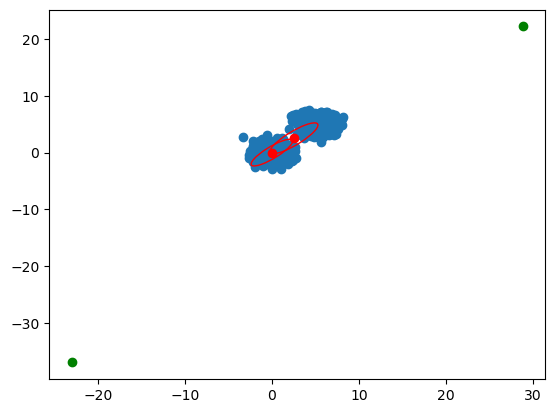

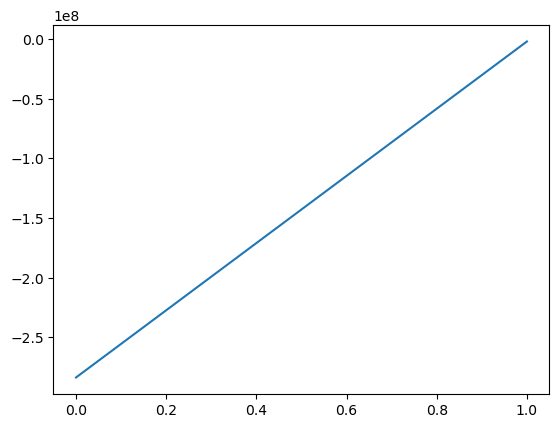

In [3]:
for i in range(3):
    test_hmmbatchcd()

Hamming Distance =  0.499


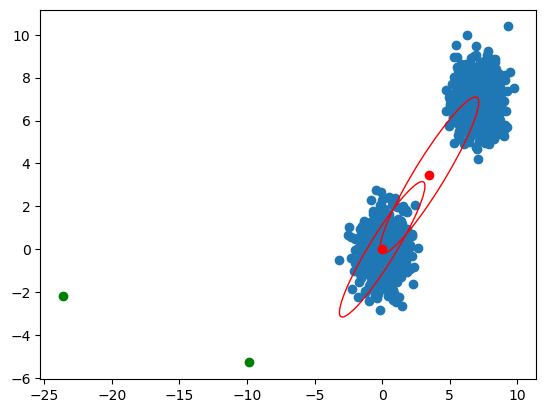

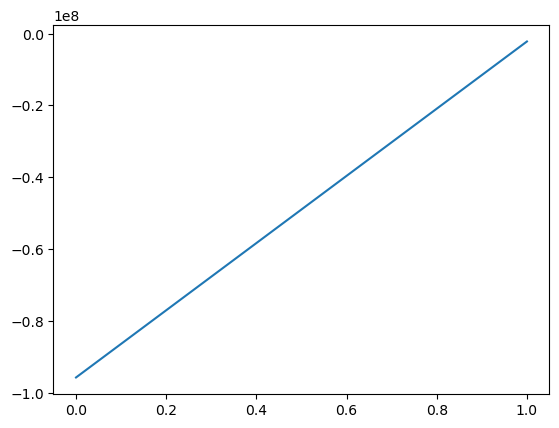

In [4]:
# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchcd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *


# generating toy data using emissions (in 2 dimensions)

K = 2           # number of states  
D = K           #have to be equal (symmetry)
kappa_0 = 0.1     #??? variance of emissions ?
nu_0 = 4        #??? smoothing?

# define priors on emission to be multivariate gaussian with 0 mean and unit var (no covariance)
emit1 = Gaussian(mu=np.array([0,0]),
                    sigma=np.eye(2),
                    mu_0=np.zeros(2),
                    sigma_0=np.eye(2),
                    kappa_0=kappa_0,
                    nu_0=nu_0)
emit2 = Gaussian(mu=np.array([7,7]),    # distance of blobs
                    sigma=np.eye(2),    # variance of blobs
                    mu_0=np.zeros(2),   # prior
                    sigma_0=np.eye(2),  # prior
                    kappa_0=kappa_0,    # prior
                    nu_0=nu_0)          # prior
emit = np.array([emit1, emit2])

# generate observations
N = 1000
obs = np.array([emit[int(np.round(i/N))].rvs()[0]
                for i in range(N)])

# set priors on emissions to be 0 mean  
# 0.75 frac of empirical covariance matrix

mu_0 = np.zeros(D)
sigma_0 = 0.75*np.cov(obs.T)
kappa_0 = 0.01
nu_0 = 4

# define emisssion RV for each state (2)
prior_emit = [Gaussian(mu_0=mu_0, sigma_0=sigma_0, kappa_0=kappa_0, 
                        nu_0=nu_0) for _ in range(K)]
prior_emit = np.array(prior_emit)           # prior on emissions retype
prior_tran = np.ones(K*K).reshape((K,K))    # prior on transition matrix all 1
prior_init = np.ones(K)                     # ?

# define object for inferrence from hmmbatchcd.py
# pass priors on init transitions and emissions for each state
hmm = HMM.VBHMM(obs, prior_init, prior_tran, prior_emit)  
hmm.infer() # do inference 

sts_true = np.array([int(np.round(i/N)) for i in range(N)]) # true states 
# hamming distance
print('Hamming Distance = ', hmm.hamming_dist(hmm.var_x, sts_true)[0]) 

# plot learned emissions over observations
util.plot_emissions(obs, prior_emit, hmm.var_emit)
plt.show()

# plot elbo over iterations
plt.plot(hmm.elbo_vec)
plt.show()

In [5]:
prior_emit

array([<pybasicbayes.distributions.gaussian.Gaussian object at 0x7fd38cd0ce80>,
      dtype=object)

In [6]:
from test_hmmbatchsgd import *

ModuleNotFoundError: No module named 'test_hmmbatchsgd'

In [34]:
T2 = np.array([
            [0.7,0.3],
            [0.6,0.4]
            ]) # this is a matrix of hidden semi states
T3  = np.array([
            [0.7,0.1,0.2],
            [0.3,0.3, 0.4],
            [0.2,0.5,0.3]
            ])

In [35]:
T2

array([[0.7, 0.3],
       [0.6, 0.4]])

In [36]:
T3

array([[0.7, 0.1, 0.2],
       [0.3, 0.3, 0.4],
       [0.2, 0.5, 0.3]])

In [243]:
# calculate hazard rates h_j(x)
from scipy.stats import poisson
# def h_j_pois(r : float, lambda_j: float):
#     h = poisson(mu = lambda_j)
#     if (1-h.cdf(x=r-1)) >= 1 : 
#         return 1
#     else:
#         return h.pmf(k=r)/(1-h.cdf(x=r-1))
def h_j_pois(r : float, lambda_j: float):
    h = poisson(mu = lambda_j)
    if (1-h.cdf(x=r-2)) >= 1 : 
        return 1
    else:
        return h.pmf(k=r-1)/(1-h.cdf(x=r-2))

    
def expand_matrix(T_hsmm, lambda_js_array , a_js_array):
    # a_js_array = np.array([2,2])
    # lambda_js_array = np.array([1,1])
    T_expanded = np.zeros((sum(a_js_array),sum(a_js_array)))
    last_index = 0
    for state in range(T_hsmm.shape[1]):
        # build h vector
        h_j_vec = np.asarray([h_j_pois(r , lambda_js_array[state]) for r in range(1,a_js_array[state]+1)])
        print(f'the 1- h vector is : {1 - h_j_vec}')
        # set diagonal matrix entries
        phi_jj = np.zeros((a_js_array[state],a_js_array[state]))
        np.fill_diagonal(phi_jj[:-1,1:], (1-h_j_vec[:-1])) #first to second to last row and second to last column
        phi_jj[-1,-1] = (1-h_j_vec[-1])
        print(f'the phi_jj is : {phi_jj}')
        # update phi_jj entries
        T_expanded[last_index:last_index+a_js_array[state],last_index:last_index+a_js_array[state]] = phi_jj#*T_hsmm[state,state]
        # update of diagonal matrices
        for state_k in range(T_hsmm.shape[1]):
            if state == state_k:
                pass # pass diagonal matrices (aleady filled)
            else:
                # calculate h_vec product with transition probability to next state
                phi_jk = h_j_vec * T_hsmm[state,state_k]
                # update matrix entries
                T_expanded[last_index:last_index+a_js_array[state] , sum(a_js_array[:state_k]) ] = phi_jk
        last_index = last_index + a_js_array[state] # add to index for jumps in loop
    return T_expanded

In [245]:
T3  = np.array([
            [0,0.8,0.2],
            [0.3,0, 0.7],
            [0.5,0.5,0]
            ])

T_hsmm = T3.copy()

a_js_array = np.array([3,2,2])
lambda_js_array = np.array([1,1,2])
a = expand_matrix(T_hsmm, lambda_js_array , a_js_array)
print(f'sum of row entries :{a.sum(axis=1)}')
a

the 1- h vector is : [0.         0.41802329 0.3038944 ]
the phi_jj is : [[0.         0.         0.        ]
 [0.         0.         0.41802329]
 [0.         0.         0.3038944 ]]
the 1- h vector is : [0.         0.41802329]
the phi_jj is : [[0.         0.        ]
 [0.         0.41802329]]
the 1- h vector is : [0.         0.68696471]
the phi_jj is : [[0.         0.        ]
 [0.         0.68696471]]
sum of row entries :[1. 1. 1. 1. 1. 1. 1.]


array([[0.        , 0.        , 0.        , 0.8       , 0.        ,
        0.2       , 0.        ],
       [0.        , 0.        , 0.41802329, 0.46558137, 0.        ,
        0.11639534, 0.        ],
       [0.        , 0.        , 0.3038944 , 0.55688448, 0.        ,
        0.13922112, 0.        ],
       [0.3       , 0.        , 0.        , 0.        , 0.        ,
        0.7       , 0.        ],
       [0.17459301, 0.        , 0.        , 0.        , 0.41802329,
        0.40738369, 0.        ],
       [0.5       , 0.        , 0.        , 0.5       , 0.        ,
        0.        , 0.        ],
       [0.15651764, 0.        , 0.        , 0.15651764, 0.        ,
        0.        , 0.68696471]])

In [208]:
T_expanded

array([[0.        , 0.41802329, 0.17459301, 0.        ],
       [0.        , 0.3038944 , 0.20883168, 0.        ],
       [0.34918602, 0.        , 0.        , 0.41802329],
       [0.41766336, 0.        , 0.        , 0.3038944 ]])

In [193]:
T_expanded.sum(axis=1)

array([0.59261631, 0.51272608, 0.76720932, 0.72155776])

In [127]:
h_j_pois(2 , 1)

2.290616692785363

In [135]:
p_cdf = poisson(mu = 1).cdf(x=2)
p_pdf = poisson(mu = 1).pmf(k=2)

1-p_cdf

0.08030139707139416

In [136]:
p_pdf

0.18393972058572114

In [137]:
p_pdf/p_cdf

0.19999999999999998

In [122]:
h_j_pois(1,1)

1.392211191177333

In [118]:
[r for r in range(1,a_js_array[state]+1)]

[1, 2, 3]

In [64]:
h_vec

array([1.39221119, 2.29061669])

In [63]:
phi_jj

array([[-0.39221119]])

In [59]:
state=1
np.asarray([h_j_pois(r , lambda_js_array[state]) for r in range(1,a_js_array[state]+1)])


array([0.45567884, 0.83715071, 1.26295783])